In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import pandas as pd
import iqplot
import zentables as zen
import bokeh.io
bokeh.io.output_notebook()
import scipy.stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Loading BokehJS ...

### Initial Cleaning of Data

In this notebook, we will analyze raw data to evaluate the hypothesis that OSMS/TI reduces time for patients undergoing SBRT. 

In the following cell, we read in the input data and clean it up so that it is analyzable. Comments within the code show specific steps taken. 

In [7]:
treatment_appt = pd.read_csv('For_Python_Treatment_Appointment.csv', sep=',')
treatment_plan = pd.read_csv('For_Python_Treatment_Plan.csv', sep=',')
# This loads in two forms of raw data. Some relevant info is in each one. 

# create a map 

# md map helps us correspond patients to each other within the two dataframes based on course series 
mdmap = treatment_plan.drop(columns = ['PatientId', 'PatientName', 'courseID', 'firstTxDTS_Course',
       'lastTxDTS_Course', 'rxName', 'Site', 'planId', 'plannedMachine',
       'Site.1', 'technique',  'NBROfFields', 'rxDosePerFraction',
       'rxNumberOfFractions', 'fractionNumber', 'txStartTime', 'TxTimeBeams',
       'txSetupTime', 'TxTimeTotal', 'kV', 'CBCT', 'diagnosisCode',
       'dxEffectiveDate', 'userBlurb'])
mdmap = mdmap.drop_duplicates(subset=['courseSer']).set_index('courseSer')

md_dict = pd.DataFrame.to_dict(mdmap)
md_dict_inside = md_dict['RxMD']


# Cleaning the dataframe
sitemap = treatment_plan.drop(columns = ['PatientId', 'PatientName', 'courseID', 'firstTxDTS_Course',
       'lastTxDTS_Course', 'rxName', 'RxMD', 'planId', 'plannedMachine',
       'Site.1', 'technique',  'NBROfFields', 'rxDosePerFraction',
       'rxNumberOfFractions', 'fractionNumber', 'txStartTime', 'TxTimeBeams',
       'txSetupTime', 'TxTimeTotal', 'kV', 'CBCT', 'diagnosisCode',
       'dxEffectiveDate', 'userBlurb'])
sitemap = sitemap.drop_duplicates(subset=['courseSer']).set_index('courseSer')

site_dict = pd.DataFrame.to_dict(sitemap)
site_dict_inside = site_dict['Site']
# the next lines contain the names of doctors that were inside the institution and outside of our main institution
# their names have been removed here for privacy and anonymity 
institution_docs = ['List of docs inside our institution']
outside_docs = ["List of docs outside our institution"]


# Mapping the two dataframes together based on course series 
treatment_appt['RxMD'] = treatment_appt['courseSer'].map(md_dict_inside)
treatment_appt['Site'] = treatment_appt['courseSer'].map(site_dict_inside)


# rename the dataframe for conveninece
merged_treatment= treatment_appt



for c in institution_docs + outside_docs:
    merged_treatment["RxMD"] = merged_treatment['RxMD'].str.replace(c + " ", c)
#create a column for if the doc is from our instiutuiton 
merged_treatment['Our Institution?'] = np.where(merged_treatment['RxMD'].isin(institution_docs), True,False)

# Our institution docschanged to OSMS starting at the beginning of 2020. Outside docs never adopted OSMS.


# set whether it was OSMS or not
# rename colluns for conveniinece 
merged_treatment = merged_treatment.rename(columns={"txStartTime": "datetime"})
merged_treatment = merged_treatment.rename(columns={"TxTimeBeams": "Beam Time"})
merged_treatment = merged_treatment.rename(columns={"txSetupTime": "Setup Time"})
merged_treatment = merged_treatment.rename(columns={"TxTimeTotal": "Total Time"})


merged_treatment["datetime"] = pd.to_datetime(merged_treatment["datetime"])
merged_treatment['OSMS'] = np.where((merged_treatment['Our Institution?']==True) & (merged_treatment["datetime"] > pd.to_datetime('2019-12-30')) , True,False)
merged_treatment['Site'] = merged_treatment['Site'].str.upper()

# here, we specify sites as multi site if there are mroe thanone prescription.
searchfor = [',']
merged_treatment["Multi?"] = merged_treatment['Prescriptions'].apply(lambda x: 1 if any(i in x for i in searchfor)else 0)
merged_treatment['Site'] = np.where(merged_treatment['Multi?']==1, 'MULTI', merged_treatment.Site)

# here, we estimate the total radiation based on previously published estimates from CBCTs and KVs . 
merged_treatment["Estimated Radiation (cGy)"] = merged_treatment['kV'] * 0.07 + merged_treatment['CBCT'] *1.8
# create a column for cbct per field
merged_treatment['CBCT/Field'] = merged_treatment['CBCT']/merged_treatment['NumberOfFields']

merged_treatment['Before 2020?']= np.where(merged_treatment['datetime'] < pd.to_datetime('2020-01-01'), True, False)
# get rid of IMRT 
merged_treatment = merged_treatment.loc[merged_treatment['Techniques']!= "IMRT HD"]

# excess cbcts are cbcts that are not striclty required to set up patient. 
merged_treatment["Excess CBCT"] = merged_treatment['CBCT'] - 1 



institution_treatment = merged_treatment[merged_treatment['Our Institution?'] == True ]

institution_treatment = institution_treatment.loc[institution_treatment['Site']!= 'SPINE']
institution_treatment = institution_treatment.loc[institution_treatment['Site']!= 'LUNG']
institution_treatment = institution_treatment.loc[institution_treatment['Site']!= 'NODE']


                                    
                                    
                                    


In [8]:
# In this section, we create individual dataframes for each site
rib_data = institution_treatment[institution_treatment['Site']=="RIB"]

femur_data= institution_treatment[institution_treatment['Site']=="FEMUR"]
acet_data = institution_treatment[institution_treatment['Site']=="ACETABULUM"]
ilium_data = institution_treatment[institution_treatment['Site']=="ILIUM"]
pelvis_data = institution_treatment[institution_treatment['Site']=="PELVIS"]
pubic_data = institution_treatment[institution_treatment['Site']=="PUBIC RAMUS"]
scapula_data = institution_treatment[institution_treatment['Site']=="SCAPULA"]
sternum_data = institution_treatment[institution_treatment['Site']=="STERNUM"]
clavicle_data = institution_treatment[institution_treatment['Site']=="CLAVICLE"]
multi_data = institution_treatment[institution_treatment['Site']=="MULTI"]

all_single_site_data = institution_treatment[institution_treatment['Site'] != "Multi"]
test_data =  merged_treatment[merged_treatment['Site']=="RIB"]



### MR Control Charts
The following functions allow for creation of the MR control chart. 

In [ ]:


def make_charts(data, site, measurement):
    
    """
    In this section, we call the class MR_ControlChart
    """
    chart = MR_ControlChart()
    chart.fit(data)
    chart.ControlChart(data, site, measurement,d2 = 1.128,D3 = 0 ,D4 = 3.267)




In [ ]:
class MR_ControlChart:
"""
This class makes the MR Control chart. 
"""
    def fit(self,data):
        
        self.X = data
        self.number_of_sample = len(self.X)
        self.mR = np.zeros(((self.number_of_sample-1),1))

       
    
    def ControlChart(self,data, site, label,  d2,D4,D3):
        first_year = self.X[0:2]
        
        # Three standard deviations 
        ucl_X   = first_year.mean() +3* np.std(first_year)
        cl_X    = first_year.mean() 
        lcl_X   = first_year.mean() - 3* np.std(first_year)
        if lcl_X <0:
            lcl_X= 0.0
      
        col=[]
        # find range of several oints in a row 
        counter = 0 
        indices = []
        for i in range(0, len(self.X)):
            if self.X[i] < cl_X: 
                counter += 1
            else: 
                counter = 0 
            if counter == 8: 
                indices.extend(list(range(i-7,i+1 )))
            if counter >8:
                indices.append(i)
            
        for i in range(0,len(self.X)):
            if i in indices:
                col.append('r')
            elif self.X[i]<lcl_X or self.X[i]> ucl_X:
                col.append('r') 
            
            else:
                col.append('b') 
      
        plt.figure(figsize=(15,5))
        x = list(range(0,len(self.X)))

       
        
        labels = ['2019Q2','2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1' ] 
        plt.plot(self.X,marker="o",c='b' )
        plt.plot([ucl_X]*len(self.X),color="r",linestyle='dashed', label="UCL={} Minutes".format(ucl_X.round(1)))
        plt.plot([cl_X]*len(self.X),color="g",label="CL={} Minutes".format(cl_X.round(1)))
        if lcl_X==0.0:
            plt.plot([lcl_X]*len(self.X),color="r",linestyle='dashed', label="LCL={} Minutes".format(lcl_X))
        else:
            plt.plot([lcl_X]*len(self.X),color="r",linestyle='dashed', label="LCL={} Minutes".format(lcl_X.round(1)))
        plt.xlabel("Quarter", fontsize=16)

        plt.ylabel("Beam Time (Minutes)", fontsize = 16)
        plt.title("{}: {}".format(site, label), fontsize=20)
        plt.xticks(np.arange(len(self.X)), labels = labels)
        plt.legend(loc='lower left')
        plt.savefig('save_path.svg') 

        plt.show()
# Functions from https://towardsdatascience.com/quality-control-charts-guide-for-python-9bb1c859c051

### Finding Average Data by Time Frame

In [5]:
    
def quarterly_avg(df):
    
    """
    This function finds the average beam time, setup time, total time, and estimated radiation
    by quarter. 
    """
    beam_time = df.groupby(pd.PeriodIndex(df['datetime'], freq="Q"))['Beam Time'].mean()
    setup_time = df.groupby(pd.PeriodIndex(df['datetime'], freq="Q"))['Setup Time'].mean()
    total_time = df.groupby(pd.PeriodIndex(df['datetime'], freq="Q"))['Total Time'].mean()
    CBCT =df.groupby(pd.PeriodIndex(df['datetime'], freq="Q"))['Estimated Radiation (cGy)'].mean()
    return pd.DataFrame(beam_time).reset_index()['Beam Time'], pd.DataFrame(setup_time).reset_index()['Setup Time'], pd.DataFrame(total_time).reset_index()['Total Time'], pd.DataFrame(CBCT).reset_index()['Estimated Radiation (cGy)']


In [4]:
def monthly_site_counts(treatment, site):
    """
    This function finds the average counts for each site by quarter
    """
    counts = pd.DataFrame(treatment.loc[treatment['Site']==site].set_index('datetime').groupby(pd.Grouper(freq='Q')).sum()['Our Institution?']).rename(columns={"Our Institution?": site})
    
    return counts

This following cell creates Table 1 in the paper. It goes and finds the number of treatments delivered by site by quarter. 

In [3]:
growing_df = monthly_site_counts(institution_treatment, "MULTI")
for c in institution_treatment['Site'].value_counts().index: 
    growing_df = growing_df.merge(monthly_site_counts(institution_treatment, c), left_on="datetime", right_on='datetime', how='outer')
df_monthly_counts_by_site = growing_df.fillna(0).drop(columns=("MULTI_y")).rename(columns={"MULTI_x": "MULTI"})


quarters_rename = {"2019-03-31": "2019 Q1", "2019-06-30": "2019 Q2", "2019-09-30": "2019 Q3", "2019-12-31": "2019 Q4",
        "2020-03-31": "2020 Q1", "2020-06-30": "2020 Q2", "2020-09-30": "2020 Q3", "2020-12-31": "2020 Q4", 
                  "2021-03-31": "2021 Q1", "2021-06-30": "2021 Q2", "2021-09-30": "2021 Q3", "2021-12-31": "2021 Q4", 
                  "2022-03-31": "2022 Q1", "2022-06-30": "2022 Q2", "2022-09-30": "2022 Q3", "2022-12-31": "2022 Q4", 
                  "2023-03-31": "2023 Q1"}
# set these as other sites because they are less common. 
other_sites = ['SCAPULA', "HUMERUS", "CLAVICLE", "MANDIBLE", "CALVARIUM", "CRANIUM", "TIBIA"]
df_monthly_counts_by_site['Other Sites'] = df_monthly_counts_by_site[other_sites].sum(axis=1)
df_monthly_counts_by_site = df_monthly_counts_by_site.drop(columns=other_sites)
df_monthly_counts_by_site_t = df_monthly_counts_by_site.T.astype(int)
df_monthly_counts_by_site_t.columns = df_monthly_counts_by_site_t.columns.astype(str)
df_monthly_counts_by_site_t = df_monthly_counts_by_site_t.rename(columns= quarters_rename)
# creates a Latex form of this table so it can be pretty. 
df_monthly_counts_by_site_t.T.to_latex(index=True,
                          escape=False,
                          longtable=False, buf= 'test7', caption = "Other Sites: Scapula, Humerus, Clavicle, Mandible, Calvarium, Cranium, Tibia")
                


NameError: name 'monthly_site_counts' is not defined

In the next cell, we call the previously written function `quarterly_avg` to find the average treatment times and radiation by site. 

In [19]:

all_beam_time, all_setup_time, all_total_time,all_rad = quarterly_avg(institution_treatment)
rib_beam_time, rib_setup_time, rib_total_time, rib_rad = quarterly_avg(rib_data)
femur_beam_time, femur_setup_time, femur_total_time, femur_rad = quarterly_avg(femur_data)
single_site_beam_time, single_site_setup_time, single_site_total_time, single_site_rad = quarterly_avg(all_single_site_data)

acet_beam_time, acet_setup_time, acet_total_time, acet_rad = quarterly_avg(acet_data)

ilium_beam_time, ilium_setup_time, ilium_total_time, ilium_rad = quarterly_avg(ilium_data)
pelvis_beam_time, pelvis_setup_time, pelvis_total_time, pelvis_rad = quarterly_avg(pelvis_data)
pubic_beam_time, pubic_setup_time, pubic_total_time, pubic_rad = quarterly_avg(pubic_data)
scapula_beam_time, scapula_setup_time, scapula_total_time, scapula_rad = quarterly_avg(scapula_data)
sternum_beam_time, sternum_setup_time, sternum_total_time, sternum_rad = quarterly_avg(sternum_data)
clavicle_beam_time, clavicle_setup_time, clavicle_total_time, clavicle_rad = quarterly_avg(clavicle_data)
multi_beam_time, multi_setup_time, multi_total_time, multi_rad = quarterly_avg(multi_data)



In the next cell, we have functions that are used to create bootstrap replicate. These are taken (with citation) form BE/Bi 103a (Caltech) course notes by Justin Bois. (https://bebi103a.github.io/lessons/17/hacker_nhst.html) 

In [221]:
name_of_site = []
osms_cbct_avg = []
cbct_cbct_avg = []
for c in [rib_all_osms, sternum_all_osms, acet_all_osms, ilium_all_osms, pr_all_osms, others_all_osms, multi_all_osms]:
    
    name_of_site.append(c['Site'].iloc[0])
    osms_cbct_avg.append(np.mean(c['CBCT'].values))
for d in [rib_all_std, sternum_all_std, acet_all_std, ilium_all_std, pr_all_std, others_all_std, multi_all_std]:
    
    cbct_cbct_avg.append(np.mean(d['CBCT'].values))
name_of_site[-2] = 'OTHER'

### Making dataframes OSMS/Non-OSMS
In the following cells, we create dataframes for all sites, separating based on whether it is all OSMS or all non-osms. 

In [ ]:
## This cell creates dataframes for all "other sites" and separates it by OSMS and Standard
others_all_std = institution_treatment.loc[institution_treatment['Site'] != "RIB"]
others_all_std = others_all_std.loc[others_all_std['Site']!= 'STERNUM']
others_all_std = others_all_std.loc[others_all_std['Site']!= 'MULTI']
others_all_std = others_all_std.loc[others_all_std['Site']!= 'ACETABULUM']
others_all_std = others_all_std.loc[others_all_std['Site']!= 'PUBIC RAMUS']
others_all_std = others_all_std.loc[others_all_std['Site']!= 'ILIUM']




others_all_osms = others_all_std.loc[others_all_std['datetime'] > pd.to_datetime('2022-02-01')]
others_all_std = others_all_std.loc[others_all_std['datetime'] < pd.to_datetime('2020-01-01')]


In [38]:
## get rib data that's all osms or all standard. 
multi_all_std = institution_treatment.loc[institution_treatment['Site'] == "MULTI"]
multi_all_osms = multi_all_std.loc[multi_all_std['datetime'] > pd.to_datetime('2022-02-01')]
multi_all_std = multi_all_std.loc[multi_all_std['datetime'] < pd.to_datetime('2020-01-01')]


In [39]:
## get rib data that's all osms or all standard. 
acet_all_std = institution_treatment.loc[institution_treatment['Site'] == "ACETABULUM"]
acet_all_osms = acet_all_std.loc[acet_all_std['datetime'] > pd.to_datetime('2022-02-01')]
acet_all_std = acet_all_std.loc[acet_all_std['datetime'] < pd.to_datetime('2020-01-01')]


In [40]:
## get rib data that's all osms or all standard. 
ilium_all_std = institution_treatment.loc[institution_treatment['Site'] == "ILIUM"]
ilium_all_osms = ilium_all_std.loc[ilium_all_std['datetime'] > pd.to_datetime('2022-02-01')]
ilium_all_std = ilium_all_std.loc[ilium_all_std['datetime'] < pd.to_datetime('2020-01-01')]


In [41]:
## get rib data that's all osms or all standard. 
pr_all_std = institution_treatment.loc[institution_treatment['Site'] == "PUBIC RAMUS"]
pr_all_osms = pr_all_std.loc[pr_all_std['datetime'] > pd.to_datetime('2022-02-01')]
pr_all_std = pr_all_std.loc[pr_all_std['datetime'] < pd.to_datetime('2020-01-01')]


In [42]:
## get rib data that's all osms or all standard. 
rib_all_std = institution_treatment.loc[institution_treatment['Site'] == "RIB"]
rib_all_osms = rib_all_std.loc[rib_all_std['datetime'] > pd.to_datetime('2021-01-01')]
rib_all_std = rib_all_std.loc[rib_all_std['datetime'] < pd.to_datetime('2020-01-01')]


In [43]:
sternum_all_std = institution_treatment.loc[institution_treatment['Site'] == "STERNUM"]
sternum_all_osms = sternum_all_std.loc[sternum_all_std['datetime'] > pd.to_datetime('2021-01-01')]
sternum_all_std = sternum_all_std.loc[sternum_all_std['datetime'] < pd.to_datetime('2020-01-01')]

### Bootstrap ECDFs 
In the following cells, we start making the bootstrap ECDFs. 

In [45]:


import numba
@numba.njit
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)

    return concat_data[:len(x)], concat_data[len(x):]


def draw_perm_reps(x, y, stat_fun, size=1):
    """Generate array of permuation replicates."""
    return np.array([stat_fun(*draw_perm_sample(x, y)) for _ in range(size)])

@numba.njit
def draw_perm_reps_diff_mean(x, y, size=1):
    """Generate array of permuation replicates."""
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)

    return out

@numba.njit
def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

In [1]:
def draw_bs_reps_diff_mean(x, y, size=1):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))

    return out

In [63]:
def make_bs_ecdf(control_dist, test_dist, label, title):
    # Shift data sets
    total_mean = np.mean(np.concatenate((control_dist, test_dist)))
    control_shift = control_dist - np.mean(control_dist) + total_mean
    test_shift = test_dist - np.mean(test_dist) + total_mean

    # Plot the ECDFs
    df_shift = pd.DataFrame(
        data={
            "treatment": ["control"] * len(control_shift)
            + ["test"] * len(test_shift),
            "Treatment Time (Minutes)": np.concatenate((control_shift, test_shift)),
        }
    )
    
    df = pd.DataFrame(
        data={
            "treatment": ["control"] * len(control_dist)
            + ["test"] * len(test_dist),
            "Treatment Time (Minutes)": np.concatenate((control_dist, test_dist)),
        }
    )
    #p = iqplot.ecdf(df_shift, q="Treatment Time (Minutes)", cats="treatment")

    #bokeh.io.show(p)
    
    
    """
    # Generate samples (10 million again)
    bs_reps = draw_bs_reps_diff_mean(control_shift.values, test_shift.values, size=10000)

    # Compute p-value
    p_val = np.sum(bs_reps >= diff_mean) / len(bs_reps)

    print("p-value =", p_val)
    """
    
    p = iqplot.ecdf(
    df,
    q="Treatment Time (Minutes)",
    cats="treatment",
    x_axis_label=label,
                title=title,
)

    for _ in range(100):
        control_rep = draw_bs_sample(control_shift.values)
        test_rep = draw_bs_sample(test_shift.values)
        df_rep = pd.DataFrame(
            data={
                "Treatment": ["CBCT Tracking"] * len(control_rep) + ["OSMS Tracking"] * len(test_rep),
                "Treatment Time (Minutes)": np.concatenate((control_rep, test_rep)),
            }
        )
        

        p = iqplot.ecdf(
            df_rep,
            q="Treatment Time (Minutes)",
            cats="Treatment",
            p=p,
            marker_kwargs=dict(alpha=0.005),
        )

    bokeh.io.show(p)

In [131]:
make_bs_ecdf(multi_all_std['Estimated Radiation (cGy)'], multi_all_osms['Estimated Radiation (cGy)'], "Estimated Radiation (cGy)", 'Multi-Site, Estimated radiation')

In [121]:
make_bs_ecdf(multi_all_std['Beam Time'], multi_all_osms['Beam Time'], "Beam Time (Minutes)", "Multi-Site SBRT OSMS Vs CBCT Monitoring: Beam Time")

In [365]:
make_bs_ecdf(others_all_std['Total Time'], others_all_osms['Total Time'], "Total Time (Minutes)", "Other Sites SBRT OSMS Vs CBCT Monitoring: Total Time")

### t-Tests
In the next cell, we run a litany of t-tests 

In [109]:
t_test_multi_total = scipy.stats.ttest_ind(others_all_osms['Beam Time'].values, others_all_std['Beam Time'].values)
t_test_pr_cbct = scipy.stats.ttest_ind(pr_all_osms['Excess CBCT'].values, pr_all_std['Excess CBCT'].values)
t_test_pr_total = scipy.stats.ttest_ind(pr_all_osms['Total Time'].values, pr_all_std['Total Time'].values)
t_test_ilium_rad = scipy.stats.ttest_ind(ilium_all_osms['Estimated Radiation (cGy)'].values, ilium_all_std['Estimated Radiation (cGy)'].values)
t_test_acet_total = scipy.stats.ttest_ind(acet_all_osms['Estimated Radiation (cGy)'].values, acet_all_std['Estimated Radiation (cGy)'].values)
t_test_others_total = scipy.stats.ttest_ind(others_all_osms['Total Time'].values, others_all_std['Total Time'].values)
t_test_others_setup = scipy.stats.ttest_ind(others_all_osms['Setup Time'].values, others_all_std['Setup Time'].values)
t_test_others_beam = scipy.stats.ttest_ind(others_all_osms['Beam Time'].values, others_all_std['Beam Time'].values)
t_test_ilium_total = scipy.stats.ttest_ind(multi_all_osms['Beam Time'].values, multi_all_std['Beam Time'].values)
t_test_sternum_rads = scipy.stats.ttest_ind(sternum_all_osms['Estimated Radiation (cGy)'].values, sternum_all_std['Estimated Radiation (cGy)'].values)
t_test_rib_rads = scipy.stats.ttest_ind(rib_all_osms['Estimated Radiation (cGy)'].values, rib_all_std['Estimated Radiation (cGy)'].values)
t_test_acet_rads = scipy.stats.ttest_ind(acet_all_osms['Estimated Radiation (cGy)'].values, acet_all_std['Estimated Radiation (cGy)'].values)
t_test_ilium_rads = scipy.stats.ttest_ind(ilium_all_osms['Estimated Radiation (cGy)'].values, ilium_all_std['Estimated Radiation (cGy)'].values)
t_test_others_rads = scipy.stats.ttest_ind(others_all_osms['Estimated Radiation (cGy)'].values, others_all_std['Estimated Radiation (cGy)'].values)
t_test_pr_rads = scipy.stats.ttest_ind(pr_all_osms['Estimated Radiation (cGy)'].values, pr_all_std['Estimated Radiation (cGy)'].values)
t_test_rib_total = scipy.stats.ttest_ind(rib_all_osms['Total Time'].values, rib_all_std['Total Time'].values)
t_test_rib_setup = scipy.stats.ttest_ind(rib_all_osms['Setup Time'].values, rib_all_std['Setup Time'].values)
t_test_rib_beam = scipy.stats.ttest_ind(rib_all_osms['Beam Time'].values, rib_all_std['Beam Time'].values)

Ttest_indResult(statistic=-7.91286740814157, pvalue=1.201399880533816e-13)

### Commanded shifts and rotations
In the next cells, we look at the commanded rotations and shifts data and plot it using iqplot. 

In [150]:
shifts = pd.read_csv('Shifts.csv',header=1)
shifts_cm = shifts.loc[shifts['Direction']!='Rotational']
shifts_rot= shifts.loc[shifts['Direction']=='Rotational'].rename(columns={'Shift (cm)':"Shift (°)"})
p = iqplot.stripbox(
    data=shifts_cm,
    q='Shift (cm)',
    cats="Direction",
    spread="jitter",
    q_axis='y'
)

bokeh.io.show(p)

Here, we make a plot showing the detection of rotational shifts. 

In [156]:
p = iqplot.stripbox(
    data=shifts_rot,
    q="Shift (°)",
    cats="Direction",
    spread="jitter",
    q_axis='y'
)

bokeh.io.show(p)

In the next cells we look at the data for patient data that compared detected shifts for 2D-3D kV-kV monitoring and OSMS monitorig

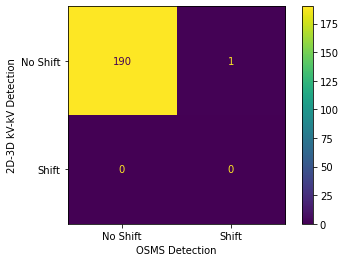

In [184]:
cm =confusion_matrix(true, OSMS_detected)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Shift", "Shift"])
disp.plot()
plt.xlabel('OSMS Detection')
plt.ylabel('2D-3D kV-kV Detection')
plt.savefig('confusion matrix')